# Project FIN404

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import seaborn as sns

sns.set_theme()

## Question 6

In [3]:

# Constantsimport numpy as np
from scipy.integrate import quad

TIME_WINDOW = 30 / 252  # From Part 2

def compute_d(tau, scale_param, decay_rate, volatility):
    exp_term = np.exp(decay_rate * tau)
    numerator = decay_rate * scale_param * exp_term
    denominator = decay_rate + 0.5 * (volatility**2) * scale_param * (exp_term - 1)
    return numerator / denominator

def _intermediate_c(u_val, scale_param, rate, vol):
    return compute_d(u_val, scale_param, rate, vol)

def evaluate_c(tau, scale_param, rate, mean_rev_level, vol):
    area_under_curve, _ = quad(_intermediate_c, 0, tau, args=(scale_param, rate, vol))
    return -rate * mean_rev_level * area_under_curve

def compute_cd(scale_param, tau, current_vol, rate, mean_reversion, volatility):
    c_part = evaluate_c(tau, scale_param, rate, mean_reversion, volatility)
    d_part = compute_d(tau, scale_param, rate, volatility)
    return c_part + d_part * current_vol

def derive_ab_constants(rate, reversion_level):
    exp_decay = np.exp(-rate * TIME_WINDOW)
    b_val = (1 - exp_decay) / rate
    a_val = reversion_level * (TIME_WINDOW - b_val)
    return a_val, b_val

def price_vix_futures(tau, curr_var, decay, target_mean, vol_of_vol):
    alpha, beta = derive_ab_constants(decay, target_mean)

    def kernel(integration_var):
        if integration_var == 0:
            return 0
        exp_component = -integration_var * alpha - compute_cd(integration_var * beta, tau, curr_var, decay, target_mean, vol_of_vol)
        return (1 - np.exp(exp_component)) / integration_var**1.5

    result, _ = quad(kernel, 1e-5, 100, limit=500)
    return (50 / np.sqrt(np.pi * TIME_WINDOW)) * result


>>> Sensitivity of VIX Futures to Current Volatility (Vt) <<<


/var/folders/mc/qf75k40s6ns_nr8c35wdmp400000gn/T/ipykernel_11458/1637402173.py:39: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  result, _ = quad(kernel, 1e-5, 100, limit=500)
/var/folders/mc/qf75k40s6ns_nr8c35wdmp400000gn/T/ipykernel_11458/1695345754.py:36: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from current font.
  plt.tight_layout()
/var/folders/mc/qf75k40s6ns_nr8c35wdmp400000gn/T/ipykernel_11458/1695345754.py:39: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from current font.
  plt.savefig("./plots/vix_sensitivity.png")
/opt/anaconda3/envs/investmentepfl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from current font.
  fig.canva

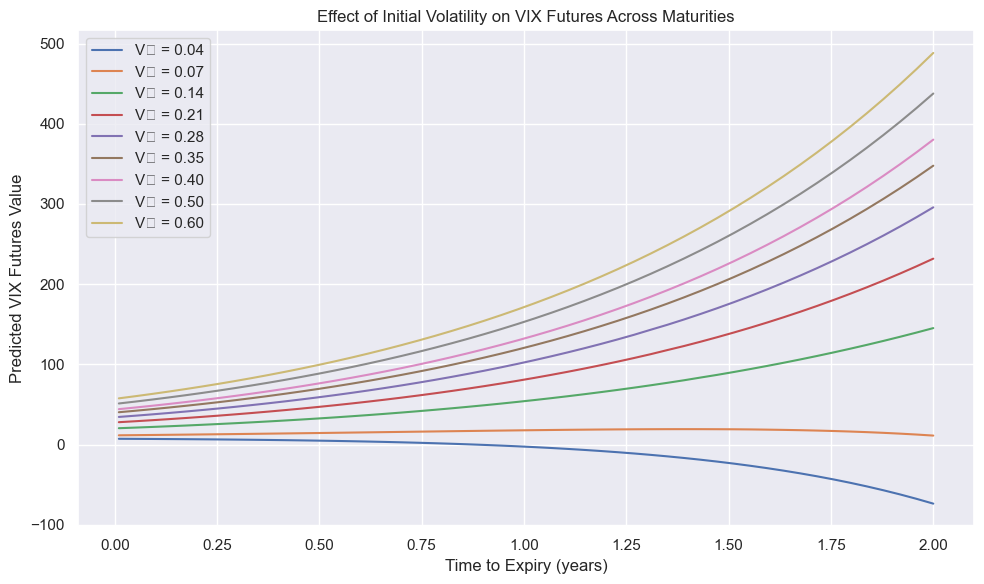

In [4]:
# Create a range of maturities (years)
maturity_horizons = np.linspace(0.01, 2.0, 50)  # spans 0.01 to 2.0 in 50 steps :contentReference[oaicite:0]{index=0}

print(">>> Sensitivity of VIX Futures to Current Volatility (Vt) <<<")

# Base model parameters
lambda_rate = 2.0
mean_reversion = 0.04
vol_volatility = 0.5

# Various initial volatility levels to evaluate
starting_variances = [0.04, 0.07, 0.14, 0.21, 0.28, 0.35, 0.40, 0.50, 0.60]

# Initialize plot area
plt.figure(figsize=(10, 6))

# Loop over each volatility scenario
for current_var in starting_variances:
    # Evaluate pricing across maturities
    fv_prices = [
        price_vix_futures(tau, current_var, lambda_rate, mean_reversion, vol_volatility)
        for tau in maturity_horizons
    ]
    plt.plot(
        maturity_horizons,
        fv_prices,
        label=f"Vₜ = {current_var:.2f}"
    )

# Labeling and styling
plt.xlabel("Time to Expiry (years)")
plt.ylabel("Predicted VIX Futures Value")
plt.title("Effect of Initial Volatility on VIX Futures Across Maturities")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()

# Save and display
plt.savefig("./plots/vix_sensitivity.png")
plt.show()


>>> Evaluating Model Sensitivity to Parameter Variations <<<


/var/folders/mc/qf75k40s6ns_nr8c35wdmp400000gn/T/ipykernel_11458/1637402173.py:39: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  result, _ = quad(kernel, 1e-5, 100, limit=500)


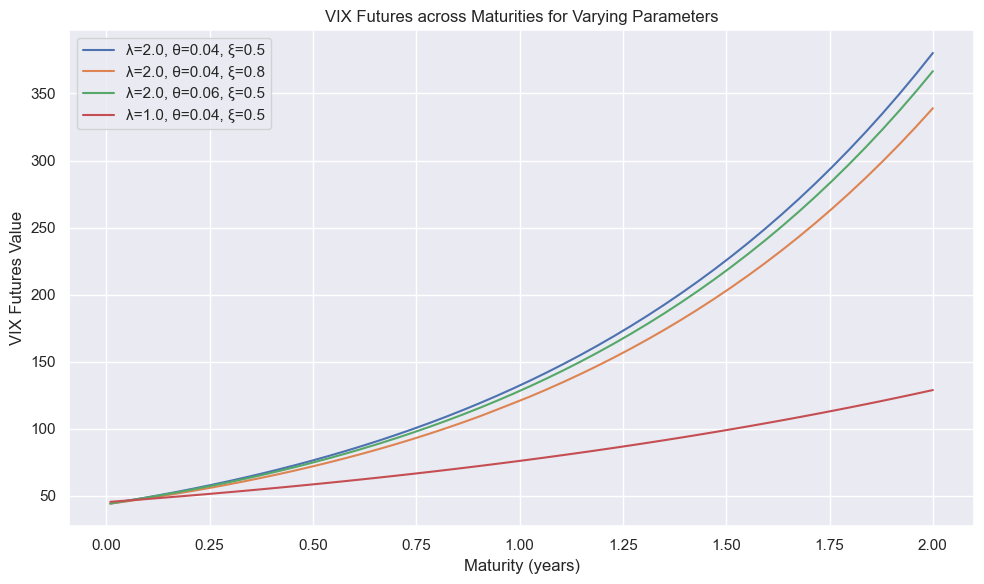

In [5]:
# --- Analysis of VIX futures under different model configurations ---

print(">>> Evaluating Model Sensitivity to Parameter Variations <<<")

# Fixed starting variance
base_volatility = 0.40

# Define parameter scenarios: (lambda, theta, xi)
scenarios = [
    (2.0, 0.04, 0.5),   # baseline
    (2.0, 0.04, 0.8),   # increased vol-of-vol
    (2.0, 0.06, 0.5),   # elevated mean reversion level
    (1.0, 0.04, 0.5)    # slower mean reversion rate
]

# Function to compute futures price series for a parameter scenario
def generate_price_series(param_tuple, vol_t0, maturities):
    lam, theta, xi = param_tuple
    return [
        price_vix_futures(tau, vol_t0, lam, theta, xi)
        for tau in maturities
    ]

# Assemble results
sensitivity_curves = {
    params: generate_price_series(params, base_volatility, maturity_horizons)
    for params in scenarios
}

# Plot configuration
plt.figure(figsize=(10, 6))
for params, curve in sensitivity_curves.items():
    lam, theta, xi = params
    label_str = f"λ={lam}, θ={theta}, ξ={xi}"
    plt.plot(maturity_horizons, curve, label=label_str)

plt.xlabel("Maturity (years)")
plt.ylabel("VIX Futures Value")
plt.title("VIX Futures across Maturities for Varying Parameters")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./plots/vix_param_sensitivity.png")
plt.show()

## Question 7

In [7]:
# ---- Function to compute the fair value of a variance futures contract ----
def price_variance_future(tau, t_start, t_current, cum_variance, v_initial, lambd, theta, xi):
    # Calculate adjusted A and B coefficients
    exp_decay = np.exp(-lambd * tau)
    B_adj = (1 - exp_decay) / lambd
    A_adj = theta * (tau - B_adj)

    # Total observation window
    total_window = tau + t_current - t_start
    if total_window <= 0:
        return np.nan  # invalid time span

    # Expected variance at maturity
    expected_var = A_adj + B_adj * v_initial

    # Normalize by time and accrue to get futures price (scaled by 10k as in contract conventions)
    return (10000 * (cum_variance + expected_var)) / total_window

# Generate maturity grid
maturities = np.linspace(0.01, 2.0, 50)

>>> Effect of Starting Volatility (Vₜ) on Variance Futures <<<


/var/folders/mc/qf75k40s6ns_nr8c35wdmp400000gn/T/ipykernel_11458/2641407.py:22: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  plt.tight_layout()
/var/folders/mc/qf75k40s6ns_nr8c35wdmp400000gn/T/ipykernel_11458/2641407.py:23: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  plt.savefig("./plots/variance_futures_v0.png")
/opt/anaconda3/envs/investmentepfl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


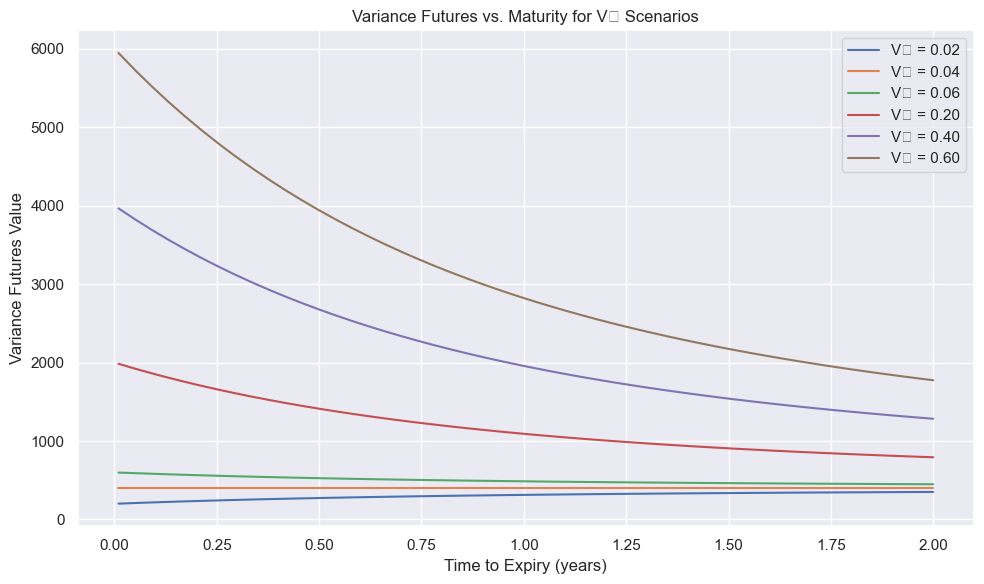

In [8]:
# Generate maturity grid
maturities = np.linspace(0.01, 2.0, 50)

# --- Section 1: Sensitivity to initial variance Vt ---
print(">>> Effect of Starting Volatility (Vₜ) on Variance Futures <<<")

base_params = dict(t_start=0.0, t_current=0.0,
                   lambd=2.0, theta=0.04, xi=0.5,
                   cum_variance=0.0)

test_Vts = [0.02, 0.04, 0.06, 0.2, 0.4, 0.6]
plt.figure(figsize=(10, 6))
for v0 in test_Vts:
    curve = [price_variance_future(tau, **base_params, v_initial=v0) for tau in maturities]
    plt.plot(maturities, curve, label=f"V₀ = {v0:.2f}")

plt.xlabel("Time to Expiry (years)")
plt.ylabel("Variance Futures Value")
plt.title("Variance Futures vs. Maturity for V₀ Scenarios")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./plots/variance_futures_v0.png")
plt.show()

>>> Exploring the Role of Accrued Variance <<<


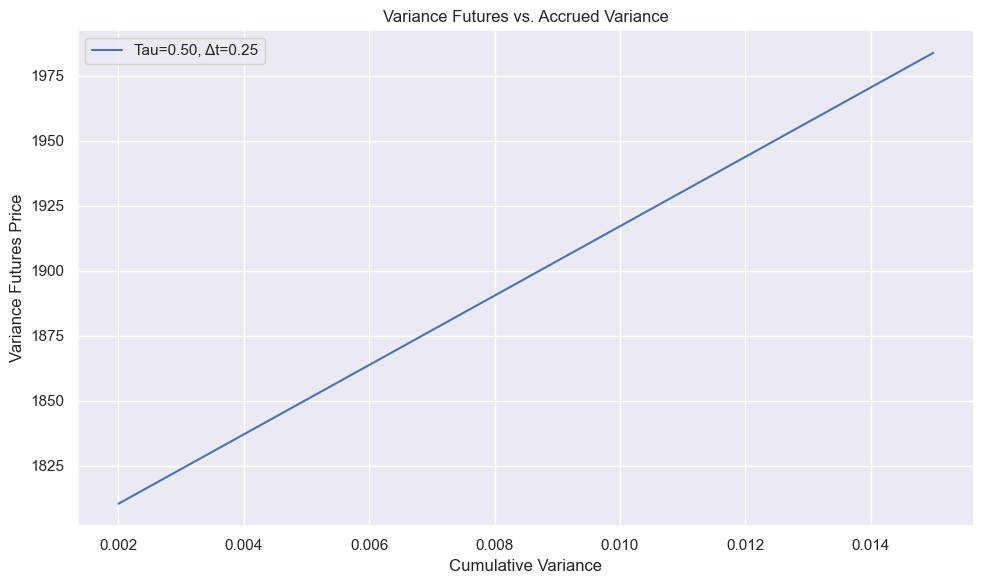

In [9]:
# --- Section 2: Impact of accrued variance on pricing ---
print(">>> Exploring the Role of Accrued Variance <<<")

fixed_params = dict(t_start=0.0, t_current=0.25,
                    tau=0.5,
                    v_initial=0.4,
                    lambd=2.0, theta=0.04, xi=0.5)

accrued_vals = np.linspace(0.002, 0.015, 50)
prices_acc = [
    price_variance_future(fixed_params['tau'],
                          fixed_params['t_start'],
                          fixed_params['t_current'],
                          a_v, fixed_params['v_initial'],
                          fixed_params['lambd'],
                          fixed_params['theta'],
                          fixed_params['xi'])
    for a_v in accrued_vals
]

plt.figure(figsize=(10, 6))
plt.plot(accrued_vals, prices_acc,
         label=f"Tau={fixed_params['tau']:.2f}, Δt={fixed_params['t_current'] - fixed_params['t_start']:.2f}")
plt.xlabel("Cumulative Variance")
plt.ylabel("Variance Futures Price")
plt.title("Variance Futures vs. Accrued Variance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./plots/variance_futures_accrued.png")
plt.show()

>>> Sensitivity to Model Parameters <<<


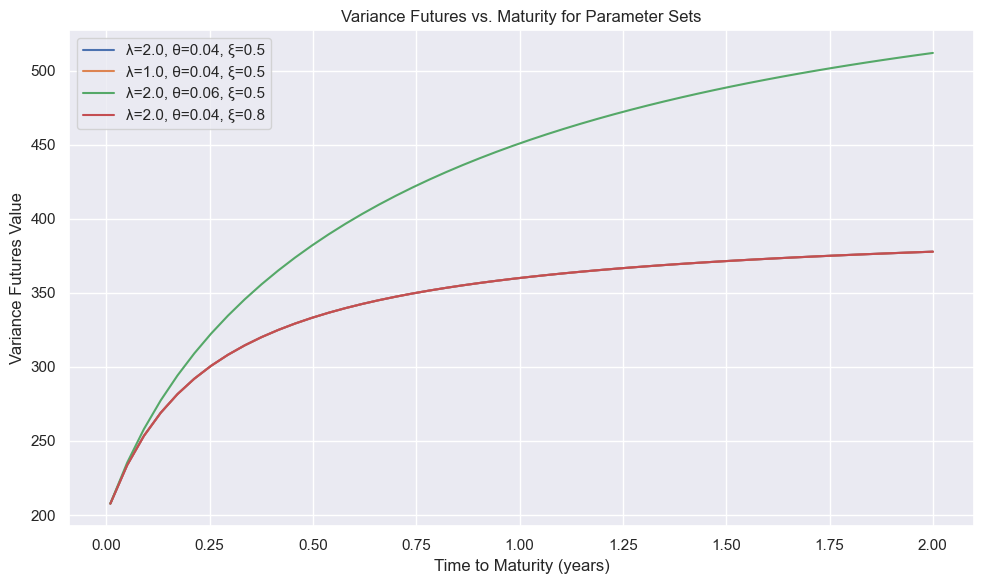

In [10]:
# --- Section 3: Parameter sensitivity analysis ---
print(">>> Sensitivity to Model Parameters <<<")

common_settings = dict(t_start=0.0, t_current=0.25,
                       v_initial=0.04, cum_variance=0.005)
param_configs = [
    (2.0, 0.04, 0.5),
    (1.0, 0.04, 0.5),
    (2.0, 0.06, 0.5),
    (2.0, 0.04, 0.8)
]

plt.figure(figsize=(10, 6))
for lam, th, xi in param_configs:
    curve = [
        price_variance_future(tau,
                               common_settings['t_start'],
                               common_settings['t_current'],
                               common_settings['cum_variance'],
                               common_settings['v_initial'],
                               lam, th, xi)
        for tau in maturities
    ]
    plt.plot(maturities, curve, label=f"λ={lam}, θ={th}, ξ={xi}")

plt.xlabel("Time to Maturity (years)")
plt.ylabel("Variance Futures Value")
plt.title("Variance Futures vs. Maturity for Parameter Sets")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./plots/variance_futures_params.png")
plt.show()


## Question 8 

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load the Excel data
df = pd.read_excel("./data/data_excel.xlsx")

df

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,Data on 09.05.2025,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,VA - S&P 500 Variance Futures,NaN,NaN,NaN,NUMBER OF DAYS,NaN,NaN
3,NaN,SYMBOL,EXPIRATION,SETTLEMENT,ACCRUED (annualize),Total,Elapsed,Remaining
4,NaN,VA/K5,2025-05-16 00:00:00,579.575681,582.219,123,119,4
5,NaN,VA/M5,2025-06-20 00:00:00,476.94509,470.917,186,159,27
6,NaN,VA/N5,2025-07-18 00:00:00,699.108234,805.347,123,77,46
7,NaN,VA/Q5,2025-08-15 00:00:00,783.27396,1092.85,120,54,66
8,NaN,VA/U5,2025-09-19 00:00:00,796.138723,1474.92,124,34,90
9,NaN,VA/V5,2025-10-17 00:00:00,517.635619,300.293,125,15,110


In [12]:
import pandas as pd
from scipy.optimize import minimize

# --- Preprocess variance futures source data ---
var_df = df.iloc[4:12].copy()
var_df.rename(columns={
    df.columns[2]: 'expiry_date',
    df.columns[3]: 'settle_price',
    df.columns[4]: 'accrued_var',
    df.columns[6]: 'days_elapsed',
    df.columns[7]: 'days_left'
}, inplace=True)
var_df['settle_price'] = pd.to_numeric(var_df['settle_price'], errors='coerce')
var_df['accrued_var'] = pd.to_numeric(var_df['accrued_var'], errors='coerce')
var_df['days_left'] = pd.to_numeric(var_df['days_left'], errors='coerce')
var_df = var_df[['settle_price', 'accrued_var', 'days_elapsed', 'days_left']]

# --- Preprocess VIX futures source data ---
vix_raw = df.iloc[15:25].copy()
vix_raw.rename(columns={
    df.columns[3]: 'vix_settlement',
    df.columns[4]: 'days_to_maturity'
}, inplace=True)
vix_raw['vix_settlement'] = pd.to_numeric(vix_raw['vix_settlement'], errors='coerce')
vix_raw['days_to_maturity'] = pd.to_numeric(vix_raw['days_to_maturity'], errors='coerce')
vix_df = vix_raw[['vix_settlement', 'days_to_maturity']]

In [15]:
vix_df

,vix_settlement,days_to_maturity
15,22.6694,0
16,22.3484,12
17,21.8897,40
18,21.7491,68
19,21.7805,103
20,21.8737,131
21,22.0178,166
22,22.1365,194
23,22.2502,222


In [16]:
var_df

,settle_price,accrued_var,days_elapsed,days_left
4,579.575681,582.219,119,4
5,476.945090,470.917,159,27
6,699.108234,805.347,77,46
7,783.273960,1092.850,54,66
8,796.138723,1474.920,34,90
9,517.635619,300.293,15,110
10,515.901565,470.908,159,154
11,619.762974,691.246,95,277


In [14]:
# --- Objective: square-error sum for calibration ---
def calibration_objective(x):
    lam, th, xi, vt0 = x
    if min(x) <= 0:
        return 1e6  # heavy penalty for invalid values

    total_error = 0.0

    # VIX futures error contribution
    for _, r in vix_df.iterrows():
        tau_years = r['days_to_maturity'] / 252
        model_val = price_vix_futures(tau_years, vt0, lam, th, xi)
        total_error += (model_val - r['vix_settlement'])**2

    # Variance futures error contribution
    for _, r in var_df.iterrows():
        tau_y = r['days_left'] / 252
        model_val = price_variance_future(
            tau_y, 0, r['days_elapsed'] / 252,
            r['accrued_var'], vt0, lam, th, xi)
        total_error += (model_val - r['settle_price'])**2

    return total_error

# --- Initial guess and parameter boundaries ---
start_point = [1.0, 0.04, 0.5, 0.04]  # [λ, θ, ξ, V₀]
param_limits = [(1e-4, 10.0), (1e-4, 1.0), (1e-4, 5.0), (1e-4, 1.0)]

# --- Run calibration routine ---
fit = minimize(calibration_objective, start_point, bounds=param_limits, method='L-BFGS-B')

lam_hat, theta_hat, xi_hat, vt_hat = fit.x

# --- Output final calibrated parameters ---
print(">>> Model Calibration Results <<<")
print(f" λ (mean reversion rate) : {lam_hat:.4f}")
print(f" θ (mean variance level) : {theta_hat:.4f}")
print(f" ξ (vol of vol)          : {xi_hat:.4f}")
print(f" V₀ (initial variance)   : {vt_hat:.4f}")


>>> Model Calibration Results <<<
 λ (mean reversion rate) : 1.0000
 θ (mean variance level) : 0.0001
 ξ (vol of vol)          : 0.5000
 V₀ (initial variance)   : 0.0001
